In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import logging
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Setup paths
BASE_DIR = Path('/home/kasinadhsarma/dr-detection/backend')
MODEL_PATH = BASE_DIR / 'models' / 'best_model.pth'

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class EnhancedDRModel(nn.Module):
    def __init__(self, num_classes=5):
        super(EnhancedDRModel, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        
        # Freeze early layers
        for param in list(self.backbone.parameters())[:-30]:
            param.requires_grad = False
            
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.backbone(x)
        return F.log_softmax(x, dim=1)

In [ ]:
class TestDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = Path(image_dir)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.image_files = sorted(list(self.image_dir.glob('*.jpeg')))
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        try:
            img_path = self.image_files[idx]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, img_path.name
        except Exception as e:
            logger.error(f"Error loading image {img_path}: {str(e)}")
            return None, None

In [ ]:
def load_model(model_path):
    model = EnhancedDRModel(num_classes=5)
    checkpoint = torch.load(model_path, map_location=device)
    
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
        
    model = model.to(device)
    model.eval()
    return model

def predict(model, test_loader):
    predictions = []
    classes = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
    
    with torch.no_grad():
        for inputs, filenames in test_loader:
            if inputs is None:
                continue
                
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            
            for prob, filename in zip(probs, filenames):
                pred_class = classes[prob.argmax().item()]
                confidence = prob.max().item()
                predictions.append({
                    'filename': filename,
                    'prediction': pred_class,
                    'confidence': confidence,
                    'probabilities': prob.cpu().numpy()
                })
                
    return predictions

In [ ]:
def visualize_predictions(predictions, num_images=3):
    classes = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
    colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c', '#c0392b']
    
    for pred in predictions[:num_images]:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Original image
        img_path = BASE_DIR / 'test' / pred['filename']
        img = Image.open(img_path).convert('RGB')
        ax1.imshow(img)
        ax1.set_title(f"Prediction: {pred['prediction']}\nConfidence: {pred['confidence']:.2%}")
        ax1.axis('off')
        
        # Probability distribution
        bars = ax2.bar(classes, pred['probabilities'], color=colors)
        ax2.set_title('Class Probabilities')
        ax2.set_ylim(0, 1)
        plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2%}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

/home/kasinadhsarma/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kasinadhsarma/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_40146/1878789163.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.

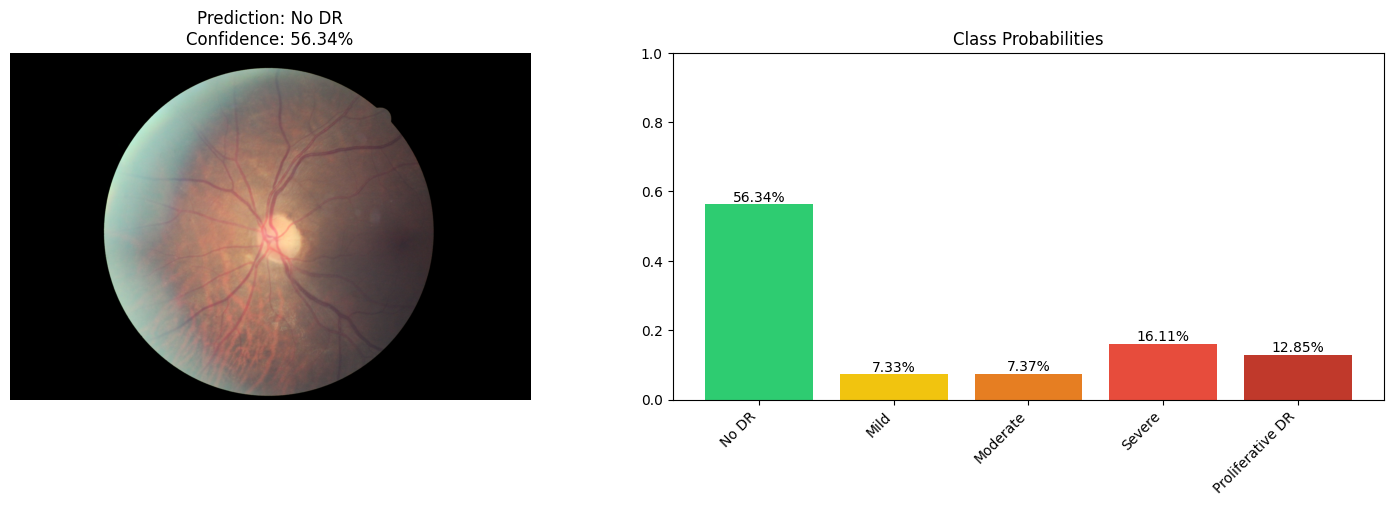

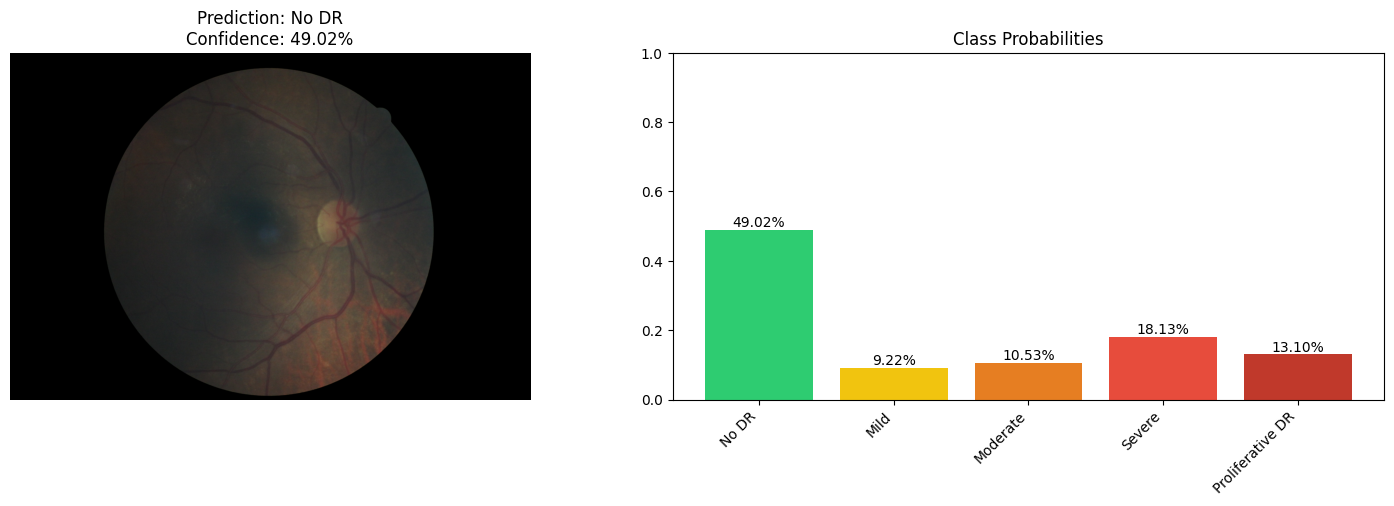

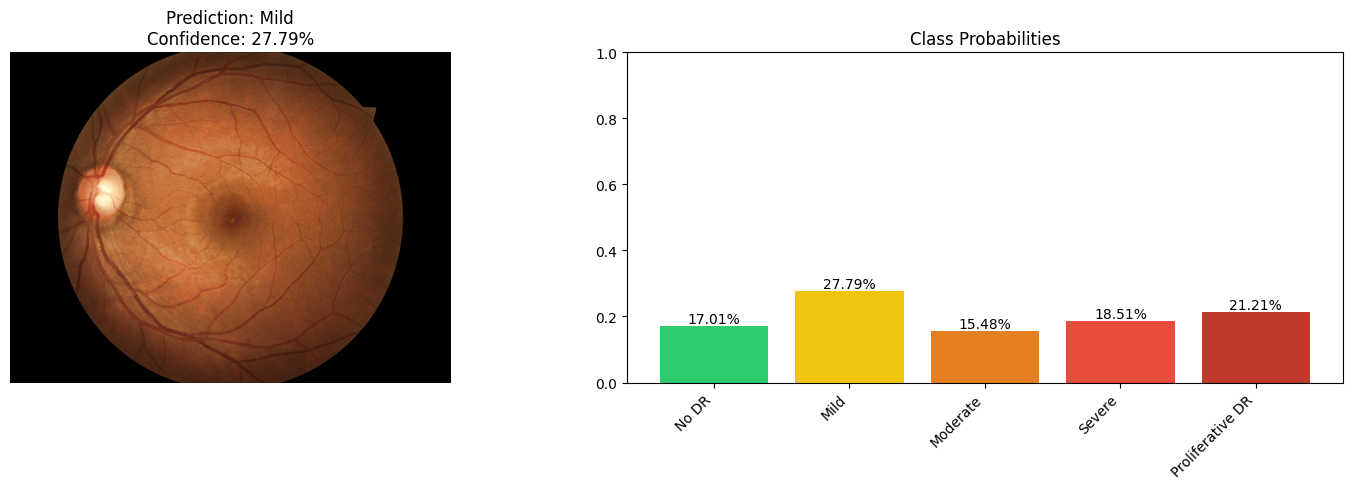

In [ ]:
# Run inference
test_dataset = TestDataset(BASE_DIR / 'test')
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

try:
    model = load_model(MODEL_PATH)
    predictions = predict(model, test_loader)
    visualize_predictions(predictions)
except Exception as e:
    logger.error(f"Error during inference: {str(e)}")